# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.core.display import Image, display

# Custom Libraries
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *

# Generate Data

First, let's generate some unlabelled data:


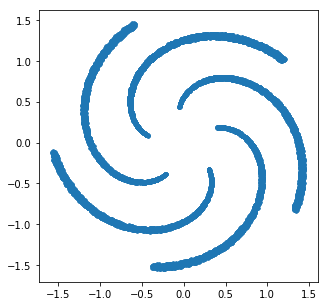

In [2]:
dataset = 2
dimensions = 2

# Dataset 1: Random Points
if dataset == 1:    
    nclusters = 4
    covariance = 2
    npoints = 1200
    minRange = 0
    maxRange = 100

    dataset = create_data(nclusters, dimensions, covariance, npoints, minrange=minRange, maxrange=maxRange,
                          labelled=False, random_flip=True, nonlinearities=True)

    if dimensions == 2:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(8,6)
        plot_data(dataset, "Unlabelled data", ax, labels=False, minrange=minRange, maxrange=maxRange, margin=30)
        plt.savefig("../Figures/unlabelled-data.pdf", bbox_inches='tight', pad_inches=0)

        plt.show()

# Dataset 2: Fermat Spiral        
elif dataset==2:
    n_points = 1500
    theta = np.linspace(np.pi/16,7*np.pi/9,n_points)
    divergence = 0.02
    a = np.random.uniform(1-divergence,1+divergence,n_points)

    x = -a*np.sqrt(theta)*np.cos(theta)
    y = a*np.sqrt(theta)*np.sin(theta)

    n_spirals = 5
    for i in range(1,5):
        x_, y_ = rotate([0,0],[x,y],i*2*np.pi/n_spirals)
        x = np.concatenate((x,x_))
        y = np.concatenate((y,y_))

    fig = plt.figure(figsize=(5,5))
    plt.scatter(x,y, marker='.')

    # save as new dataset
    dataset = np.asarray([x,y]).T
    minRange = np.min(x)
    maxRange = np.max(x)

#### Create single Density Tree

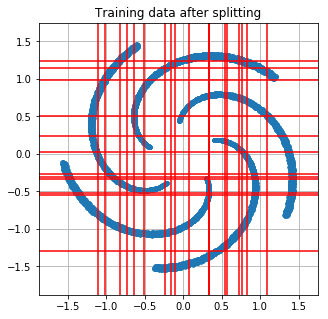

In [11]:
import warnings
warnings.filterwarnings("ignore")
max_depth = 4
min_subset = .001
root = create_density_tree(dataset, max_depth=max_depth, min_subset=min_subset, verbose=False)

def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

cut_vals, cut_dims = get_values_preorder(root, [], [])
cut_vals = np.asarray(cut_vals).astype(float)
cut_dims = np.asarray(cut_dims).astype(int)

# show splits
x_split = cut_vals[cut_dims == 0]
y_split = cut_vals[cut_dims == 1]

if dimensions == 2:
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    plot_data(dataset, "Training data after splitting", ax, labels=False, lines_x=x_split, lines_y=y_split,
              minrange=minRange, maxrange=maxRange, margin=.3)

    %clear
    plt.show()

#### Showing all Clusters Covariances

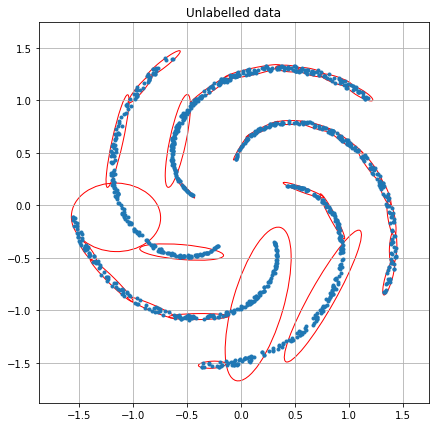

[1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1] [ 0.23605808 -0.15997931 -0.52856037 -0.63762905 -1.02227779 -1.29001324
 -0.3409659  -1.10835571 -0.73679571  1.08446606 -0.30331203  0.34053026
  0.72759005 -0.26857334 -0.54661752  0.01806966  0.9894949   0.32856207
 -0.23876661 -0.82259813  0.07233118  0.82823141  0.57091567  0.50201623
  0.33627027 -0.50853536  1.23319941 -0.11221704  0.76456319  0.54626463
  1.14231251]


In [12]:
covs, means = get_clusters(root, [], [])

if dimensions == 2:
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    fig.set_size_inches(7,7)
    plot_data(draw_subsamples(dataset,.05), "Unlabelled data", ax, labels=False, n_clusters=5, covs=covs, means=means,
              minrange = minRange, maxrange = maxRange, margin=.3)
    plt.savefig("../Figures/unlabelled-data-cov.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
    print(cut_dims, cut_vals)

# Printing the Tree

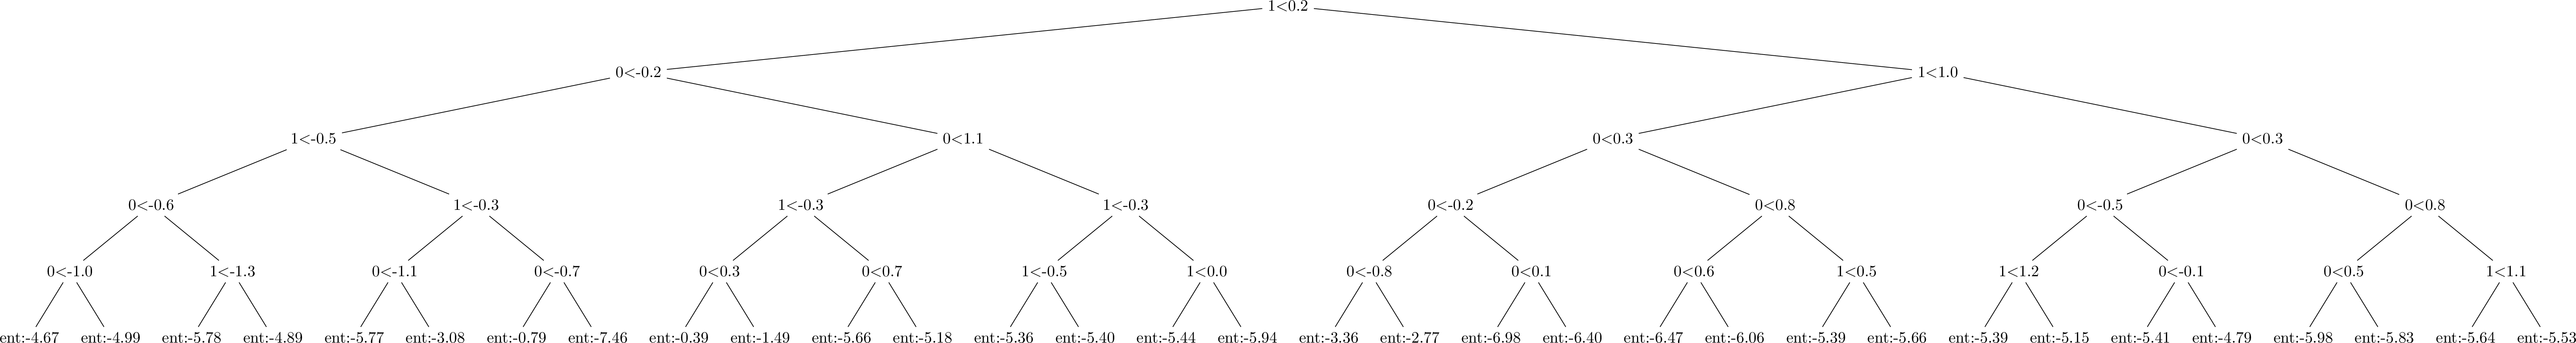

In [13]:
# requires LaTeX, imagemagick to be installed
    
def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root, tree_string)
    
    os.system("cd ../Figures; rm density-tree.tex; more main_pt1.tex >> density-tree.tex; echo '' >> density-tree.tex;")
    os.system("cd ../Figures; echo '" + tree_string + "' >> density-tree.tex;  more main_pt2.tex >> density-tree.tex;")
    os.system("cd ../Figures; /Library/TeX/texbin/pdflatex density-tree.tex; convert -density 300 -trim density-tree.pdf -quality 100 density-tree.png")
    os.system("cd ../Figures; rm *.aux *.log")
    display(Image('../Figures/density-tree.png', retina=True))
    
tree_visualize(root)

In [14]:
from scipy.stats import multivariate_normal

def get_proba(pt, roots, thresh):
    """Get proba for one point"""
    probas_pt = []
    for root in roots:
        d_mean, d_cov, d_pct = descend_density_tree(pt, root)

        # probability for this point to be from this distribution
        if d_pct > thresh:
            probas_pt.append(multivariate_normal.pdf(pt, d_mean, d_cov)*d_pct)
    return np.nanmean(probas_pt)


def create_plot_surface_(minRange, maxRange, roots, n_jobs, n_points_dim=100, thresh=.1):
    grid = np.linspace(minRange, maxRange, n_points_dim)
    x, y = np.meshgrid(grid,grid)
    grid = np.vstack((y.flatten(),x.flatten())).T

    if n_jobs == -1:
        n_jobs = multiprocessing.cpu_count()
    probas = Parallel(n_jobs=n_jobs, verbose=10)(delayed(get_proba)(pt, roots, thresh) for pt in grid)
    
    probas = np.reshape(probas, (n_points_dim, n_points_dim))
    return probas

from scipy.stats import multivariate_normal

# loop
def create_plot_surface(minRange, maxRange, roots, n_points_dim=100, thresh=.1):
    grid = np.linspace(minRange, maxRange, n_points_dim)
    probas_out = np.zeros((n_points_dim,n_points_dim))

    
    for idx_x, pt in tqdm(enumerate(grid)):
        for idx_y, g in enumerate(grid):
            proba_pt=[]
            for root in roots:
                # descend tree
                d_mean, d_cov, d_pct = descend_density_tree([pt, g], root)
        
                # probability for this point to be from this distribution
                if d_pct > thresh:
                    proba_pt.append(multivariate_normal.pdf([pt, g], d_mean, d_cov)*d_pct)
                
            probas_out[idx_y, idx_x] = np.nanmean(proba_pt)

    return probas_out
    fig = plt.figure(figsize=(7,7))
    plt.imshow(probas_out)

100it [00:01, 57.76it/s]


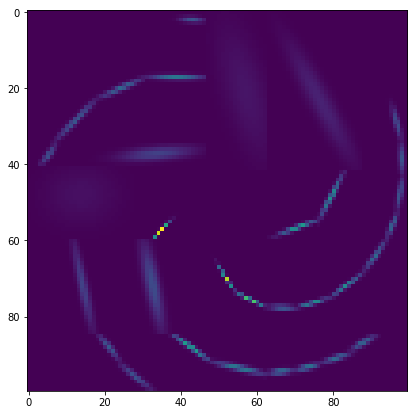

In [15]:
probas = create_plot_surface(minRange, maxRange, [root], n_points_dim=100, thresh=0)
fig = plt.figure(figsize=(7,7))
plt.imshow(probas)
plt.savefig("../Figures/density_tree/spirals_one_tree_maxDepth"+str(max_depth)+".pdf", bbox_inches='tight', pad_inches=0)

#### Descend tree (predict "label")

In [16]:
# for all points 
probas = []
probas_other = []
for d in dataset:
    # descend tree
    d_mean, d_cov, d_pct = descend_density_tree(d,root)

    # probability for this point to be from this distribution
    probas.append(multivariate_normal.pdf(d, d_mean, d_cov)*d_pct)
    for i in range(5):
        probas_other.append(multivariate_normal.pdf(d, means[i], covs[i])*d_pct)
    
print("Probability to come from the leaf node cluster: %.5f%%" % np.mean(probas))
print("Probability to come from an arbitrary cluster: %.5f%%" % np.mean(probas_other))

Probability to come from the leaf node cluster: 1.01678%
Probability to come from an arbitrary cluster: 0.02403%


#### Density Forest

In [17]:
n_trees = 10
subsample_pct = .1
# min_subset

root_nodes = density_forest_create(dataset, max_depth=max_depth, min_subset=min_subset, 
                                   n_trees=n_trees, subsample_pct=subsample_pct, n_jobs=-1)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    2.6s finished


100it [00:12,  7.69it/s]


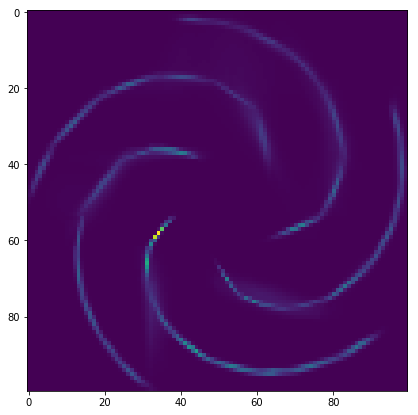

In [22]:
probas = create_plot_surface(minRange, maxRange, root_nodes, n_points_dim=100, thresh=0.002)
fig = plt.figure(figsize=(7,7))
plt.imshow(probas)
plt.savefig("../Figures/density_tree/spirals_forest_maxDepth"+str(max_depth)+"_nTrees"+str(n_trees)+"_pct"+str(subsample_pct)+".pdf", bbox_inches='tight', pad_inches=0)